In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
from glob import glob
import os
import tensorflow as tf
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import re
from tensorflow.keras.applications import EfficientNetB0, MobileNet
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPool2D, Concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

## Preparing the Dataset

In [60]:
desired_H = 64
desired_W = 128

def preprocess(path):
  image = tf.io.read_file(path)

  image = tf.io.decode_jpeg(image)

  image = tf.image.resize(image, (64,128))

  image = image/255
  return image

In [61]:
image_paths = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data_8','train_data','*.jpg')))
images_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
images_dataset = images_dataset.map(preprocess)

json_labels_path = '/content/drive/MyDrive/car_tag_data/data_8/train_label'
labels_list_2D = [] # this list will have information for 8 rectangles in all samples, so it will be number_of_samples*8*4
for filename in sorted(os.listdir(json_labels_path)):
    labels_list_1D = [] # this list will have information for 8 rectangles in a single sample image, so it will be 8*4
    f = open(os.path.join(json_labels_path, filename))
    data = json.load(f)
    img_W, img_H = data['images'][0]['width'],data['images'][0]['height']
    for annotation in data['annotations']:
        rounded_labels_list_1D = [float(number/img_W) if idx%2==0 else float(number/img_H) for idx, number in enumerate(annotation['bbox'])]
        labels_list_1D.append(rounded_labels_list_1D)
    
    labels_list_2D.append(labels_list_1D)


labels_dataset = tf.data.Dataset.from_tensor_slices(labels_list_2D)
train_dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
# Shuffle and batch the data
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset_batched = train_dataset.batch(1)

In [62]:
# test_images
image_paths = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data_8','test_data','*.jpg')))
test_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
test_dataset = test_dataset.map(preprocess)
test_dataset = test_dataset.shuffle(len(test_dataset))
test_dataset_batched = test_dataset.batch(1)

## Visualizing the data

In [63]:
iterator = iter(train_dataset)

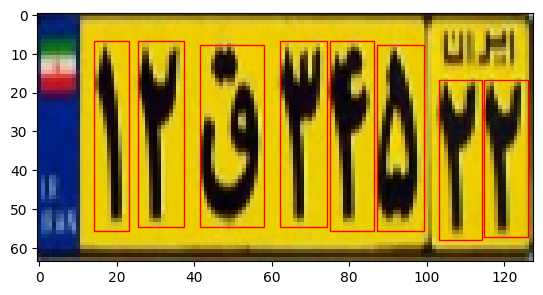

In [64]:
i = next(iterator)
img = i[0]
label = i[1]
fig, ax = plt.subplots(1)
for r in label:
  rect = plt.Rectangle((r[0]*desired_W ,r[1]*desired_H), r[2]*desired_W,r[3]*desired_H,
                        linewidth = 1,
                        edgecolor = 'r', 
                        facecolor = 'none')
  ax.imshow(img)
  ax.add_patch(rect)


## Create and train a model

In [66]:
def create_model(input_shape): # (64,128,3)

  input_layer = Input(shape=input_shape)
  x = Conv2D(filters=8, kernel_size=(5,5), padding="same", activation="relu")(input_layer)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=64, kernel_size=(1,1), padding="same", activation="relu")(x)
  x = Flatten()(x)
  x = Dense(units=128, activation="relu")(x)
  out_1 = Dense(units= 4, activation="sigmoid")(x)
  out_2 = Dense(units= 4, activation="sigmoid")(x)
  out_3 = Dense(units= 4, activation="sigmoid")(x)
  out_4 = Dense(units= 4, activation="sigmoid")(x)
  out_5 = Dense(units= 4, activation="sigmoid")(x)
  out_6 = Dense(units= 4, activation="sigmoid")(x)
  out_7 = Dense(units= 4, activation="sigmoid")(x)
  out_8 = Dense(units= 4, activation="sigmoid")(x)
  out = Concatenate(axis = 0)([out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8])
  model = Model(inputs=input_layer, outputs=out)
  return model

In [67]:
def loss_fn(y,y_hat):
  return tf.reduce_mean(binary_crossentropy(y,y_hat))

In [68]:
model = create_model((64,128,3))
model.compile(loss=loss_fn, optimizer=Adam())

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset_batched,epochs=30)

## Visualize the results on train data

In [71]:
iterator = iter(train_dataset_batched)

1/1 [==============================] - 0s 27ms/step


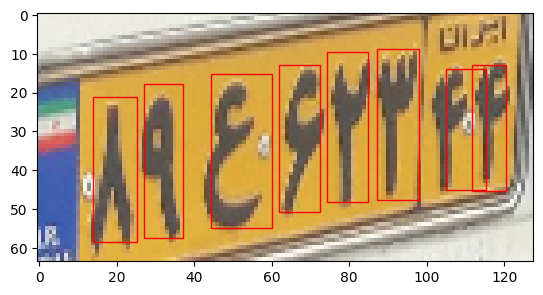

In [76]:
i = next(iterator)
img = tf.squeeze(i[0])
label = model.predict(i[0])
fig, ax = plt.subplots(1)
for r in label:
  rect = plt.Rectangle((r[0]*desired_W ,r[1]*desired_H), r[2]*desired_W,r[3]*desired_H,
                        linewidth = 1,
                        edgecolor = 'r', 
                        facecolor = 'none')
  ax.imshow(img)
  ax.add_patch(rect)


## Visualize the data on test data

In [77]:
iterator_ = iter(test_dataset_batched)

1/1 [==============================] - 0s 28ms/step


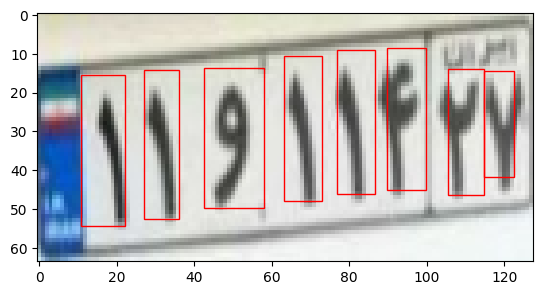

In [80]:
i_ = next(iterator_)
img = tf.squeeze(i_)
label = model.predict(i_)
fig, ax = plt.subplots(1)
for r in label:
  rect = plt.Rectangle((r[0]*desired_W ,r[1]*desired_H), r[2]*desired_W,r[3]*desired_H,
                        linewidth = 1,
                        edgecolor = 'r', 
                        facecolor = 'none')
  ax.imshow(img)
  ax.add_patch(rect)

## Utility function to crop the characters

In [82]:
# defining a function to crop chars for char reader model
def crop_chars(img,annotations,is_batched=False,show_chars=True,char_shape=(32,32),span_pixels=0):
  img = tf.squeeze(img)
  shape = (img.shape[-3],img.shape[-2])
  if is_batched:
    batch_size = img.shape[0]
    chars = np.zeros((batch_size,8,char_shape[0],char_shape[1],3))
    for i,img_ in enumerate(img):
      for j,rect in enumerate(annotations[i]):
        # print(rect.shape)
        x_top_left = rect[0]
        y_top_left = rect[1]
        width = rect[2]
        height = rect[3]
        x_top_left ,y_top_left ,width,height = np.multiply(rect,np.array([shape[1],shape[0],shape[1],shape[0]]))
        x_top_left,y_top_left,width,height = int(x_top_left),int(y_top_left),int(width+span_pixels),int(height+span_pixels)
        detected_object = img_[y_top_left-span_pixels:y_top_left+height,x_top_left-span_pixels:x_top_left+width,:]
        chars[i,j,:,:,:] = np.array(tf.image.resize(detected_object, char_shape))
        if show_chars:
          fig, ax = plt.subplots(batch_size,8,j*(i+1)+1)
          ax.imshow(chars[i,j])
  else:
    chars = np.zeros((8,char_shape[0],char_shape[1],3))
    for j,rect in enumerate(annotations):
      x_top_left = rect[0]
      y_top_left = rect[1]
      width = rect[2]
      height = rect[3]
      x_top_left ,y_top_left ,width,height = np.multiply(rect,np.array([shape[1],shape[0],shape[1],shape[0]]))
      x_top_left,y_top_left,width,height = int(x_top_left),int(y_top_left),int(width+span_pixels),int(height+span_pixels)
      detected_object = img[y_top_left-span_pixels:y_top_left+height,x_top_left-span_pixels:x_top_left+width,:]
      print(type(tf.image.resize(detected_object, char_shape)))
      print(type(chars))
      chars[j,:,:,:] = np.array(tf.image.resize(detected_object, char_shape))
      if show_chars:
        ax = plt.subplot(1,8,j+1)
        ax.imshow(chars[j])
  return chars

1/1 [==============================] - 0s 37ms/step
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>


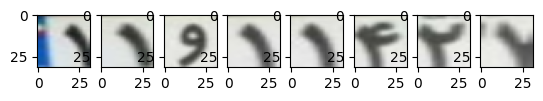

In [83]:
chars = crop_chars(img,model.predict(i_),span_pixels=1)